In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch import optim
from torchvision.datasets import SVHN, MNIST
from torchvision import transforms
from tqdm import tqdm

from src.data_utils import TransformDataset
from src.models import get_model
from src.reproducibility import set_seed

In [2]:
# 入力画像サイズ
INPUT_SIZE = 32

# learning rate
LR = 5e-5

# エポック数
EPOCHS = 10

In [3]:
def get_mnist_transform():
    train_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.RandomCrop(size=INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    valid_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    return train_transform, valid_transform


def get_mnist_dl(batch_size=32):
    train_transform, valid_transform = get_mnist_transform()
    train_mnist = MNIST(
        root='./mnist/',
        train=True,
        download=True,
    )
    test_mnist = MNIST(
        root='./mnist/',
        train=False,
        download=True,
        transform=valid_transform
    )
    split_generator = torch.Generator().manual_seed(2024)
    train_mnist, val_mnist = random_split(train_mnist, [0.8, 0.2], split_generator)
    train_mnist, val_mnist = TransformDataset(train_mnist, transform=train_transform), TransformDataset(val_mnist, transform=valid_transform)
    dl_generator = torch.Generator().manual_seed(2024)
    train_dl = DataLoader(
        train_mnist,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
    )
    valid_dl = DataLoader(
        val_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    test_dl = DataLoader(
        test_mnist,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return train_dl, valid_dl, test_dl


def get_svhm_transform():
    train_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.RandomCrop(size=INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    valid_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    return train_transform, valid_transform


def get_svhm_dl(batch_size=32):
    train_transform, valid_transform = get_svhm_transform()
    train_svhm = SVHN(
        root='./svhm/',
        split='train',
        download=True,
    )
    test_svhm = SVHN(
        root='./svhm/',
        split='test',
        download=True,
        transform=valid_transform
    )
    split_generator = torch.Generator().manual_seed(2024)
    train_svhm, val_svhm = random_split(train_svhm, [0.8, 0.2], split_generator)
    train_svhm, val_svhm = TransformDataset(train_svhm, transform=train_transform), TransformDataset(val_svhm, transform=valid_transform)
    dl_generator = torch.Generator().manual_seed(2024)
    train_dl = DataLoader(
        train_svhm,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        generator=dl_generator,
    )
    valid_dl = DataLoader(
        val_svhm,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    test_dl = DataLoader(
        test_svhm,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
    )
    return train_dl, valid_dl, test_dl



def train(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    epochs,
    train_dl,
    valid_dl,
    device,
):
    logs = {
        'train_accuracy': [],
        'train_loss': [],
        'valid_accuracy': [],
        'valid_loss': [],
    }
    for epoch in range(epochs):
        train_accuracy, train_avg_loss = train_one_epoch(
            G,
            F,
            optimizer_G,
            optimizer_F,
            loss_fn,
            train_dl,
            device,
        )
        valid_accuracy, valid_avg_loss = evaluate(
            G,
            F,
            loss_fn,
            valid_dl,
            device
        )
        logs['train_accuracy'].append(train_accuracy)
        logs['train_loss'].append(train_avg_loss)
        logs['valid_accuracy'].append(valid_accuracy)
        logs['valid_loss'].append(valid_avg_loss)

        print(f'epoch: {epoch + 1} train loss={train_avg_loss:.3f}, train acc={train_accuracy:.3f}, valid loss={valid_avg_loss:.3f}, valid acc={valid_accuracy:.3f}')
    return logs


def train_one_epoch(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    train_dl,
    device,
):
    G.train()
    F.train()
    total_correct = 0
    total_data = 0
    total_loss = 0
    def zero_grad():
        optimizer_G.zero_grad()
        optimizer_F.zero_grad()

    for X, y in tqdm(train_dl, total=len(train_dl)):
        zero_grad()
        X = X.to(device)
        y = y.to(device)
        pred = F(G(X))
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer_G.step()
        optimizer_F.step()

        num_data = len(X)
        total_data += num_data
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_loss += loss.item() * total_data
    accuracy = total_correct / total_data
    avg_loss = total_loss / total_data
    return accuracy, avg_loss


@torch.no_grad()
def evaluate(G, F, loss_fn, valid_dl, device):
    G.eval()
    F.eval()
    total_correct = 0
    total_data = 0
    total_loss = 0
    for X, y in tqdm(valid_dl, total=len(valid_dl)):
        X = X.to(device)
        y = y.to(device)
        pred = F(G(X))
        loss = loss_fn(pred, y)

        num_data = len(X)
        total_data += num_data
        total_correct += (torch.argmax(pred, dim=1) == y).sum().item()
        total_loss += loss.item() * total_data
    accuracy = total_correct / total_data
    avg_loss = total_loss / total_data
    return accuracy, avg_loss

== train mnist ==


100%|██████████| 375/375 [00:00<00:00, 398.96it/s]


epoch: 1 train loss=195.817, train acc=0.868, valid loss=18.609, valid acc=0.970


100%|██████████| 375/375 [00:00<00:00, 439.28it/s]


epoch: 2 train loss=89.177, train acc=0.961, valid loss=10.534, valid acc=0.983


100%|██████████| 375/375 [00:00<00:00, 440.50it/s]


epoch: 3 train loss=65.641, train acc=0.971, valid loss=8.093, valid acc=0.987


100%|██████████| 375/375 [00:00<00:00, 394.05it/s]


epoch: 4 train loss=55.270, train acc=0.977, valid loss=7.458, valid acc=0.988


100%|██████████| 375/375 [00:00<00:00, 418.92it/s]


epoch: 5 train loss=47.702, train acc=0.979, valid loss=6.193, valid acc=0.990


100%|██████████| 375/375 [00:00<00:00, 406.46it/s]


epoch: 6 train loss=44.707, train acc=0.981, valid loss=5.578, valid acc=0.991


100%|██████████| 375/375 [00:00<00:00, 416.84it/s]


epoch: 7 train loss=39.588, train acc=0.983, valid loss=5.680, valid acc=0.991


100%|██████████| 375/375 [00:00<00:00, 399.26it/s]


epoch: 8 train loss=37.019, train acc=0.984, valid loss=4.745, valid acc=0.992


100%|██████████| 375/375 [00:00<00:00, 430.69it/s]


epoch: 9 train loss=33.524, train acc=0.986, valid loss=5.126, valid acc=0.991


100%|██████████| 375/375 [00:00<00:00, 422.21it/s]


epoch: 10 train loss=32.514, train acc=0.987, valid loss=4.600, valid acc=0.993


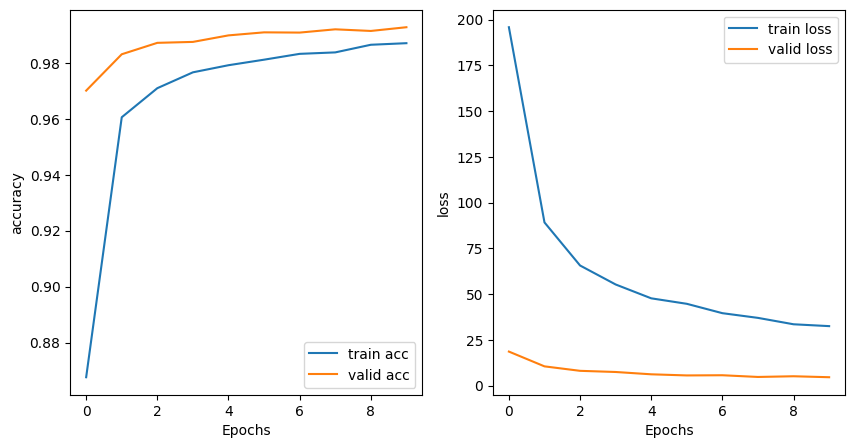

==test on mnist==


100%|██████████| 313/313 [00:00<00:00, 416.13it/s]


test loss=0.993, test acc=0.993
==test on svhm==
Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


100%|██████████| 814/814 [00:02<00:00, 341.08it/s]

test loss=0.064, test acc=0.064


In [4]:
print('== train mnist ==')
set_seed(0)
G, F = get_model(model_type='cnn', num_feature_extractor_out=512)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G.to(device)
F.to(device)
mnist_train_dl, mnist_valid_dl, mnist_test_dl = get_mnist_dl()
loss_fn = nn.CrossEntropyLoss()
optimizer_G = optim.AdamW(G.parameters(), lr=LR, weight_decay=0.0005)
optimizer_F = optim.AdamW(F.parameters(), lr=LR, weight_decay=0.0005)
logs = train(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    epochs=EPOCHS,
    train_dl=mnist_train_dl,
    valid_dl=mnist_valid_dl,
    device=device,
)

# epochごとのloss, accuracyをプロット
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].plot(logs['train_accuracy'], label='train acc')
axes[0].plot(logs['valid_accuracy'], label='valid acc')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[1].plot(logs['train_loss'], label='train loss')
axes[1].plot(logs['valid_loss'], label='valid loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()
plt.show()

print('==test on mnist==')
test_accuracy, test_avg_loss = evaluate(
    G,
    F,
    loss_fn,
    mnist_test_dl,
    device,
)
print(f'test loss={test_accuracy:.3f}, test acc={test_accuracy:.3f}')

print('==test on svhm==')
svhm_train_dl, svhm_valid_dl, svhm_test_dl = get_svhm_dl()
test_accuracy, test_avg_loss = evaluate(
    G,
    F,
    loss_fn,
    svhm_test_dl,
    device,
)
print(f'test loss={test_accuracy:.3f}, test acc={test_accuracy:.3f}')

== train svhm ==
Using downloaded and verified file: ./svhm/train_32x32.mat
Using downloaded and verified file: ./svhm/test_32x32.mat


100%|██████████| 458/458 [00:01<00:00, 378.44it/s]


epoch: 1 train loss=1705.993, train acc=0.284, valid loss=291.009, valid acc=0.550


100%|██████████| 458/458 [00:01<00:00, 368.88it/s]


epoch: 2 train loss=1082.842, train acc=0.578, valid loss=192.419, valid acc=0.729


100%|██████████| 458/458 [00:01<00:00, 322.20it/s]


epoch: 3 train loss=853.002, train acc=0.684, valid loss=152.887, valid acc=0.789


100%|██████████| 458/458 [00:01<00:00, 355.60it/s]


epoch: 4 train loss=727.778, train acc=0.740, valid loss=138.812, valid acc=0.806


100%|██████████| 458/458 [00:01<00:00, 320.73it/s]


epoch: 5 train loss=650.258, train acc=0.768, valid loss=127.748, valid acc=0.826


100%|██████████| 458/458 [00:01<00:00, 359.38it/s]


epoch: 6 train loss=591.602, train acc=0.790, valid loss=112.495, valid acc=0.845


100%|██████████| 458/458 [00:01<00:00, 363.85it/s]


epoch: 7 train loss=548.507, train acc=0.808, valid loss=105.079, valid acc=0.858


100%|██████████| 458/458 [00:01<00:00, 345.98it/s]


epoch: 8 train loss=518.015, train acc=0.820, valid loss=102.779, valid acc=0.860


100%|██████████| 458/458 [00:01<00:00, 333.18it/s]


epoch: 9 train loss=478.259, train acc=0.833, valid loss=95.750, valid acc=0.868


100%|██████████| 458/458 [00:01<00:00, 330.04it/s]


epoch: 10 train loss=455.410, train acc=0.840, valid loss=92.450, valid acc=0.875


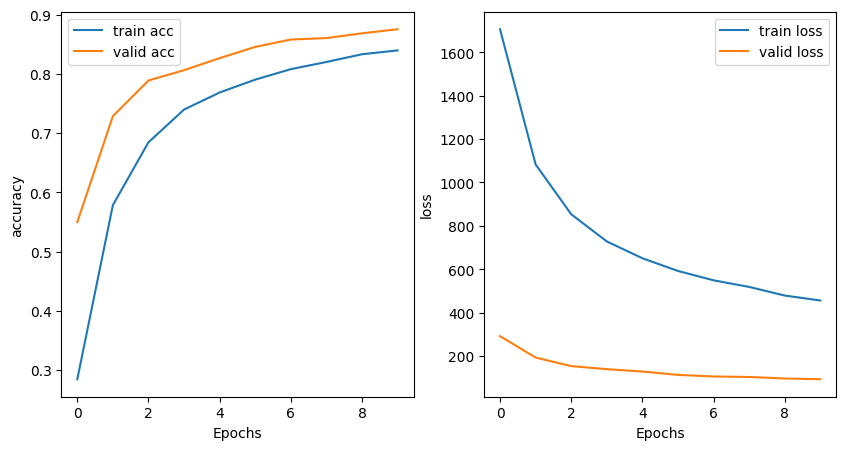

==test on svhm==


100%|██████████| 814/814 [00:02<00:00, 376.33it/s]


test loss=0.884, test acc=0.884
==test on mnist==


100%|██████████| 313/313 [00:00<00:00, 350.44it/s]

test loss=0.631, test acc=0.631


In [7]:
print('== train svhm ==')
set_seed(0)
G, F = get_model(model_type='cnn', num_feature_extractor_out=512)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G.to(device)
F.to(device)
mnist_train_dl, mnist_valid_dl, mnist_test_dl = get_svhm_dl()
loss_fn = nn.CrossEntropyLoss()
optimizer_G = optim.AdamW(G.parameters(), lr=LR, weight_decay=0.0005)
optimizer_F = optim.AdamW(F.parameters(), lr=LR, weight_decay=0.0005)
logs = train(
    G,
    F,
    optimizer_G,
    optimizer_F,
    loss_fn,
    epochs=EPOCHS,
    train_dl=mnist_train_dl,
    valid_dl=mnist_valid_dl,
    device=device,
)

# epochごとのloss, accuracyをプロット
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].plot(logs['train_accuracy'], label='train acc')
axes[0].plot(logs['valid_accuracy'], label='valid acc')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[1].plot(logs['train_loss'], label='train loss')
axes[1].plot(logs['valid_loss'], label='valid loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()
plt.show()

print('==test on svhm==')
test_accuracy, test_avg_loss = evaluate(
    G,
    F,
    loss_fn,
    mnist_test_dl,
    device,
)
print(f'test loss={test_accuracy:.3f}, test acc={test_accuracy:.3f}')

print('==test on mnist==')
svhm_train_dl, svhm_valid_dl, svhm_test_dl = get_mnist_dl()
test_accuracy, test_avg_loss = evaluate(
    G,
    F,
    loss_fn,
    svhm_test_dl,
    device,
)
print(f'test loss={test_accuracy:.3f}, test acc={test_accuracy:.3f}')